# Part 7: Deployment
- This section aims to simplify the machine learning model into a simple and usable app that punters can use to decide whether to make a bet or not.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import f1_score, roc_curve, auc, confusion_matrix, average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

import joblib
import pickle
import time

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
# Read in the train file
df_train = pd.read_csv('./data/df_train.csv')
df_train.reset_index(inplace=True, drop=True)

# Read in the test file
df_test = pd.read_csv('./data/df_test.csv')
df_test.reset_index(inplace=True, drop=True)

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23500 entries, 0 to 23499
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   finishing_position     23500 non-null  int64  
 1   horse_number           23500 non-null  float64
 2   horse_name             23500 non-null  object 
 3   horse_id               23500 non-null  object 
 4   jockey                 23500 non-null  object 
 5   trainer                23500 non-null  object 
 6   actual_weight          23500 non-null  int64  
 7   declared_horse_weight  23500 non-null  int64  
 8   draw                   23500 non-null  int64  
 9   length_behind_winner   23500 non-null  object 
 10  running_position_1     23500 non-null  float64
 11  running_position_2     23500 non-null  float64
 12  running_position_3     23500 non-null  float64
 13  running_position_4     13299 non-null  float64
 14  finish_time            23500 non-null  object 
 15  wi

In [4]:
# Keep the features we want to train our model on
df = df_train[['horse_name', 'horse_number', 'jockey',
                'actual_weight', 'declared_horse_weight',
                    'draw', 'win_odds', 'jockey_ave_rank',
                     'recent_ave_rank', 'race_distance', 'HorseWin', 'HorseRankTop3']]

dftest = df_test[['horse_name', 'horse_number', 'jockey',
                 'actual_weight', 'declared_horse_weight',
                'draw', 'win_odds', 'jockey_ave_rank',    
                 'recent_ave_rank', 'race_distance', 'HorseWin', 'HorseRankTop3']]

In [5]:
df.notnull().sum()

horse_name               23500
horse_number             23500
jockey                   23500
actual_weight            23500
declared_horse_weight    23500
draw                     23500
win_odds                 23500
jockey_ave_rank          23500
recent_ave_rank          23500
race_distance            23500
HorseWin                 23500
HorseRankTop3            23500
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23500 entries, 0 to 23499
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   horse_name             23500 non-null  object 
 1   horse_number           23500 non-null  float64
 2   jockey                 23500 non-null  object 
 3   actual_weight          23500 non-null  int64  
 4   declared_horse_weight  23500 non-null  int64  
 5   draw                   23500 non-null  int64  
 6   win_odds               23500 non-null  float64
 7   jockey_ave_rank        23500 non-null  float64
 8   recent_ave_rank        23500 non-null  float64
 9   race_distance          23500 non-null  int64  
 10  HorseWin               23500 non-null  int64  
 11  HorseRankTop3          23500 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 2.2+ MB


In [7]:
# Use the below code if we want to encode certain features, else we dont have to use this.
# # instantiate labelencoder object
# le_horse_name = LabelEncoder()

# # apply le on categorical feature columns
# df['horse_name'] = le_horse_name.fit_transform(df['horse_name'])

# # instantiate labelencoder object
# le_jockey = LabelEncoder()

# # apply le on categorical feature columns
# df['jockey'] = le_jockey.fit_transform(df['jockey'])


In [8]:
# After encoding, we can see that the horse_name and jockey columns are now integers
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23500 entries, 0 to 23499
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   horse_name             23500 non-null  object 
 1   horse_number           23500 non-null  float64
 2   jockey                 23500 non-null  object 
 3   actual_weight          23500 non-null  int64  
 4   declared_horse_weight  23500 non-null  int64  
 5   draw                   23500 non-null  int64  
 6   win_odds               23500 non-null  float64
 7   jockey_ave_rank        23500 non-null  float64
 8   recent_ave_rank        23500 non-null  float64
 9   race_distance          23500 non-null  int64  
 10  HorseWin               23500 non-null  int64  
 11  HorseRankTop3          23500 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 2.2+ MB


In [9]:
df.head()

,horse_name,horse_number,jockey,actual_weight,declared_horse_weight,draw,win_odds,jockey_ave_rank,recent_ave_rank,race_distance,HorseWin,HorseRankTop3
0,DOUBLE DRAGON,1.0,B Prebble,133,1032,1,3.8,6.052910,1.0,1400,1,1
1,PLAIN BLUE BANNER,2.0,D Whyte,133,1075,13,8.0,5.825153,2.0,1400,0,1
2,GOLDWEAVER,10.0,Y T Cheng,121,1065,3,5.7,7.857759,3.0,1400,0,1
3,SUPREME PROFIT,3.0,J Moreira,132,1222,2,6.1,4.179172,4.0,1400,0,0
4,THE ONLY KID,7.0,Z Purton,125,1136,9,6.1,5.284127,5.0,1400,0,0


In [10]:
## split df into X and y
X_train = df.drop(['horse_name', 'horse_number', 'jockey', 'HorseWin', 'HorseRankTop3'], axis=1)
y_train = df['HorseWin']

# split dftest into X and y
X_test = dftest.drop(['horse_name', 'horse_number', 'jockey', 'HorseWin', 'HorseRankTop3'], axis=1)
y_test = dftest['HorseWin']

In [11]:
# Smote the training data
sm = SMOTE(random_state = 42)
rfc = RandomForestClassifier(max_depth=20, min_samples_leaf=10,
                               random_state = 42)

# Steps for the pipeline
steps = [('smote', sm), ('rfc', rfc)]

# Create the pipeline
smote_rfc = Pipeline(steps = steps)

In [12]:
# Fit the pipeline to the training data
smote_rfc.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('rfc',
                 RandomForestClassifier(max_depth=20, min_samples_leaf=10,
                                        random_state=42))])

### Checking if the model is ok

In [13]:
# Specify kfold cross validation
kfold = KFold(n_splits=5)

# Calculate the cross validation score
cv_score = cross_val_score(smote_rfc, X_train, y_train, cv=kfold, scoring='f1_weighted').mean()
cv_score = round(cv_score, 3)

# Create a dataframe to store the predictions
df_pred = pd.DataFrame()
df_pred['RaceID'] = df_test['race_id']
df_pred['HorseID'] = df_test['horse_id']

# Make predictions
y_test_pred = smote_rfc.predict(X_test)

# Store the predictions in the dataframe
df_pred['HorseWin'] = y_test_pred

# Calculate the f1 score
f1 = f1_score(y_test, y_test_pred, average='weighted')
f1 = round(f1, 3)

# Calculate PR AUC
pr_auc = average_precision_score(y_test, y_test_pred, average='weighted')
pr_auc = round(pr_auc, 3)

# Calculate TPR
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
tpr = tp / (tp + fn)
tpr = round(tpr, 3)

 # Print the results
print('Cross Validation Score: ', cv_score)
print('F1 Score: ', f1)
print('PR AUC (Avg Precision): ', pr_auc)
print('TPR: ', tpr)


Cross Validation Score:  0.858
F1 Score:  0.847
PR AUC (Avg Precision):  0.147
TPR:  0.481


In [14]:
# Define a function to backtest the betting strategy
def simple_class_strategy(model_pred, graph=True):

    df_test_results = df_test[['finishing_position', 'win_odds', 
                                'race_id', 
                               'HorseWin', 'horse_id']]

    # rename columns
    df_test_results = df_test_results.rename(columns={'race_id': 'RaceID', 
                                                    'horse_id': 'HorseID', 
                                                    'HorseWin':'ActualWin'})
    
    # merge the prediction with the test data
    df_backtest = pd.merge(model_pred, df_test_results, on=('RaceID', 'HorseID'), how='left')

    money = 0
    bets_made = []
    cumulative_money = [0]

    for race_id in df_backtest['RaceID'].unique():

        # make a temporary dataframe one for that particular race
        temp_df = df_backtest[df_backtest['RaceID']==race_id]

        # find out the bets we made
        bets = temp_df[temp_df['HorseWin']==1]

        # deduct money for bets we made
        deduction  = -len(bets)

        # amount won from bets
        # sum of multiplying the odds with the prediction
        amount_won = sum(bets['win_odds']*bets['ActualWin'])
        
        # add the amount won to the money
        money += (amount_won + deduction)

        # append the money to the cumulative money list
        cumulative_money.append(money)

        # append the bets made to the bets made list
        bets_made.append(len(bets))
    
    if graph==True:
        # plot the cumulative money
        plt.figure(figsize=(10, 6))
        plt.plot(cumulative_money)
        plt.title('Cumulative Money')
        plt.xlabel
        plt.show()

        # plot the bets made
        plt.figure(figsize=(10, 6))
        plt.plot(bets_made)
        plt.title('Bets Made')
        plt.show()

    # print the final money and bets made
    print('Final Money: ', round(money, 3))
    print('Total Bets Made: ', round(sum(bets_made),3), '\n')

    return money, bets_made

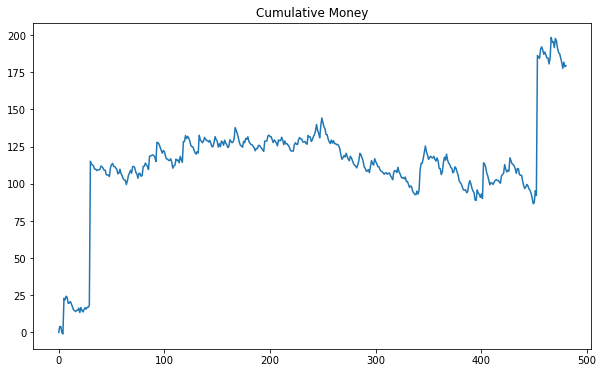

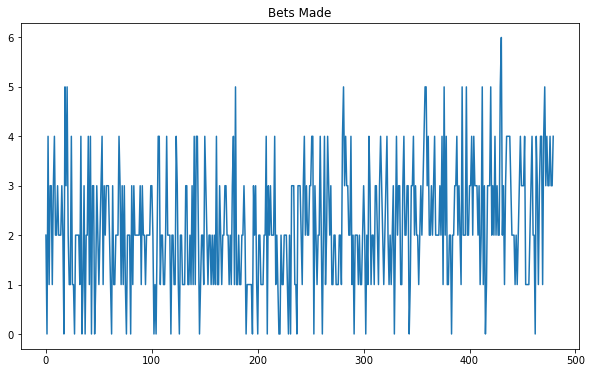

Final Money:  179.4
Total Bets Made:  1052 



In [15]:
# Check that the strategy works
app_testing = simple_class_strategy(df_pred, graph=True)

In [16]:
# Save predictions to csv
pd.DataFrame(df_pred).to_csv('./predictions/deploy_pred.csv')


In [17]:
# pickle the model

# create the data to pickle
data = {"model": smote_rfc, 'train_data': df_train, 'test_data': df_test}

# open a file, where you ant to store the data
file = open('saved_steps.pkl', 'wb')

# dump information to that file
pickle.dump(data, file)

### For demo purpose

In [18]:
# We want to be able to show that our deployment app is working
# Find index of df_pred where HorseWin = 1
index = df_pred[df_pred['HorseWin']==1].index

# Pass the index through to the test data
horsesPred1 = df_test.iloc[index]

# Keep only the columns we need
horsesPredCol = ['horse_name', 'horse_number', 'jockey', 'draw', 'win_odds', 'race_distance',
                'actual_weight', 'declared_horse_weight', 'recent_ave_rank',
                'finishing_position', 'HorseWin', 'jockey_ave_rank', 'trainer_ave_rank']

In [19]:
horsesPred1[horsesPredCol][:20]

,horse_name,horse_number,jockey,draw,win_odds,race_distance,actual_weight,declared_horse_weight,recent_ave_rank,finishing_position,HorseWin,jockey_ave_rank,trainer_ave_rank
0,POWERMAX,5.0,N Callan,9,6.0,1200,126,1124,2.750000,1,1,6.438751,6.715420
2,ROYALE ELEGANCE,3.0,O Murphy,1,4.5,1200,131,1090,4.480000,3,0,8.103093,7.048587
27,VICTORY MARVEL,8.0,O Doleuze,5,9.2,1650,121,1183,3.833333,4,0,6.797508,6.730798
29,UNICORN,7.0,Z Purton,2,4.3,1650,124,1075,5.300000,6,0,5.284127,6.680328
30,AMAZING AGILITY,2.0,B Prebble,4,6.5,1650,130,1026,7.400000,7,0,6.052910,6.611465
33,HOME RUN,9.0,S de Sousa,8,8.9,1650,120,1111,4.200000,10,0,6.150407,6.888713
37,MOMENT OF POWER,3.0,K K Chiong,3,4.0,1000,127,1069,2.375000,2,0,6.499033,6.182123
48,SPEEDY LONGWAH,5.0,A Badel,2,27.0,1650,125,1128,5.400000,1,1,7.166667,6.680328
50,DYNAMISM,3.0,K Teetan,5,7.5,1650,127,1157,6.350000,3,0,6.691367,6.611465
58,PEOPLE'S KNIGHT,7.0,S Clipperton,10,4.0,1650,124,1154,5.294118,11,0,6.848624,6.135968
